# Simulating VGPs from Model G as PSV model

PSV generates dispersion on the observed VGPs. PSV has been succesfully described by Model G (McFadden et al., 1988) which has the form of a second order polynomial:

$$
S^2 = a^2 + (b\lambda)^2
$$

where $a$ and $b$ are constants that define the value of S (angular dispersion of VGPs) at the equator and the rate of its increase with palaeolatitude ($\lambda$),
respectively.

For the last 10Ma, these constants were calculated by Doubrovine et al. (2019), as $a=11.3^{+1.3}_{-1.1}$ and $b=0.27^{+0.04}_{-0.08$


### Rationale: The concept is that if we can establish a functional correlation $f(\kappa)=S$ between $\kappa$ (used to generate direction from a Fisher distribution) and $S$, then we could replicate VGPs from Model G through simulation.


In [3]:
import numpy as np
import scipy as scp
import pandas as pd
import matplotlib as mpl
from pmagpy.pmag import dir2cart, cart2dir
import pmagpy.ipmag as ipmag
import seaborn as sns

# Import curve fitting package from scipy
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

In [4]:
def cartesian2spherical(v):  
    """
    Take an array of lenght 3 correspoingt to a 3-dimensional vector and returns a array of lenght 2
    with co-latitade and longitude
    """
    theta = np.arcsin(v[2])         #facu     theta = np.arccos(v[2]) 
    phi = np.arctan2(v[1], v[0])
        
    return [theta, phi]

def spherical2cartesian(v):
    """
    v[0] = theta - Latitude
    """
    
    x = np.cos(v[0]) * np.cos(v[1])  # x = np.sin(v[0]) * np.cos(v[1])
    y = np.cos(v[0]) * np.sin(v[1])  # y = np.sin(v[0]) * np.sin(v[1])
    z = np.sin(v[0])                 # z = np.cos(v[0])
    
    return [x,y,z]

def GCD_cartesian(cartesian1, cartesian2):
    '''
    great circle distance between two vectors in cartesian coordinates
    '''
    dot = np.dot(cartesian1, cartesian2)
    if abs(dot) > 1: dot = round(dot)    
    gcd =  np.arccos(dot)
    
    return gcd

In [3]:
def fisher_mean(a):
    """takes an np.array of [[x,y,z],[x1,x2,x3],...] 
    return the fisherian mean [cartesian]"""
    
    suma = a.sum(axis = 0)
    
    R = np.sqrt(suma[0]**2 + suma[1]**2 + suma[2]**2)    
    
    return suma / R

In [4]:
def angular_dispersion(cartesian_array):
    """
    takes an array [[x,y,z],[x1,y1,z1], ... , [xn,yn,zn]] of direction cosines, calculates its Fisherian mean
    and then the angular standart deviation (S) in radians following Cox (1970)
    """  
    mean = fisher_mean(cartesian_array)
    distances = np.array([GCD_cartesian(mean,x) for x in cartesian_array])
       
    return np.mean(distances)

In [5]:
def angular_dispersion_input_kappa(N, kappa):
    
    """
    Draws a sample of N VGPs that follows a Fisher distribution with
    Paraters (N, mean, kappa) and then computes its Fisherian mean
    along with the angular dispersion of that sample (it resembles a paleomagnetiic study):
    N = number of cartesian directions
    cartesian_mean = Mean of the sample
    kappa = concentration parameter
    """    
    DI = cart2dir([0,0,1])
    directions = ipmag.fishrot(k = kappa, n = N, dec = DI[0], inc=DI[1], di_block = True)
    PP = [dir2cart(i) for i in directions]
    PP = np.array(PP)    

    return angular_dispersion(PP) #mean[cartesians] and S [radians]               

### I want to find an empirical relationship between $\kappa$ and $S$.

I will set a simulation in which we draw random samples from a fisher distribution with a growing kappa and N. For each, we calculate the angular dispersion (S)

In [6]:
%%time
ks = range(5,150)
Ns = range(5,100)

Ss = []
Sizes = []
kappas = []

for k in ks:
    for N in Ns:
        Ss.append(angular_dispersion_input_kappa(N, k))
        Sizes.append(N)
        kappas.append(k)
        
dictionary = {'dispersion': Ss,
              'N': Sizes,
              'kappa': kappas}
             
out = pd.DataFrame(dictionary)

Wall time: 1min 58s


<AxesSubplot:xlabel='kappa', ylabel='dispersion'>

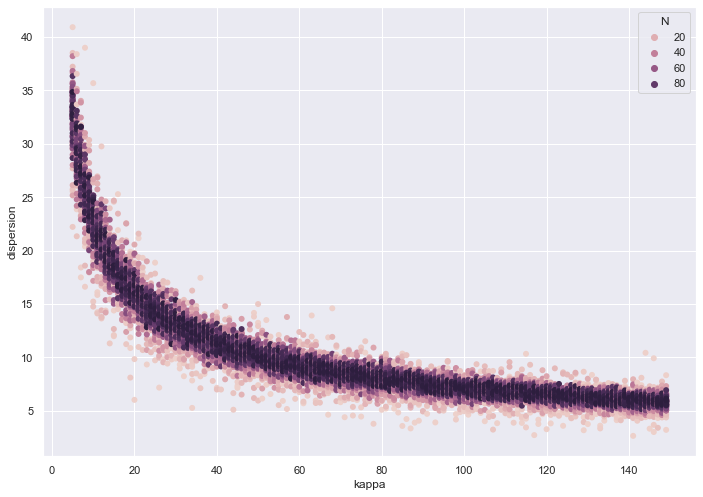

In [7]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.scatterplot(x = out['kappa'], y = np.degrees(out['dispersion']), hue = out['N'], linewidth=0)

## Fitting the curve to a Power-Law distribution

In [8]:
# set the function
def power_law(x, a, b):
    return a*np.power(x, b)

In [9]:
x = out['kappa'].to_numpy()
y = np.degrees(out['dispersion'].to_numpy())

how it looks in log-log scale ?

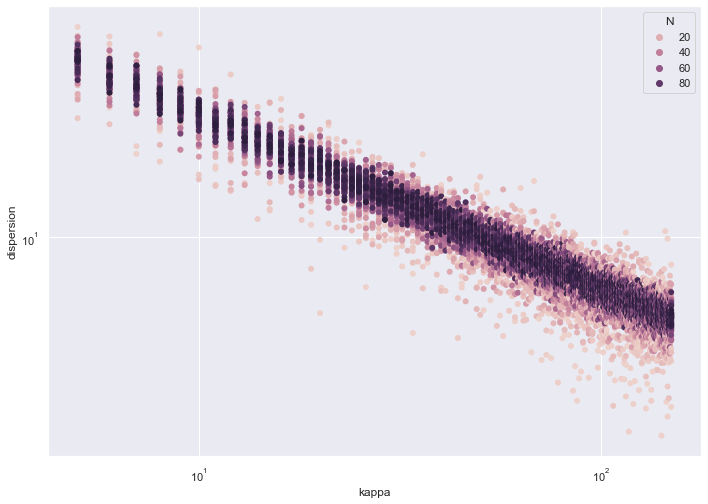

In [10]:
fig, ax = plt.subplots()
ax = sns.scatterplot(x = out['kappa'], y = np.degrees(out['dispersion']), hue = out['N'], linewidth=0)

ax.set_yscale('log')
ax.set_xscale('log')
# Set the y-ticks
ax.yaxis.set_major_locator(mpl.ticker.LogLocator(base=10.0))

# Fit

In [13]:
# Fit the data
pars, cov = curve_fit(f=power_law, xdata=x, ydata=y, p0=[0, 0], bounds=(-np.inf, np.inf))

# Get the standard deviations of the parameters (square roots of the # diagonal of the covariance)
stdevs = np.sqrt(np.diag(cov))

# Calculate the residuals
res = y - power_law(x, *pars)

Fitted curve

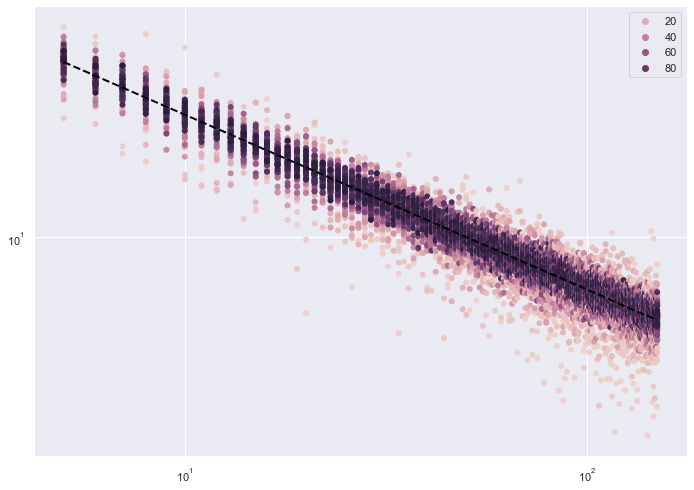

In [15]:
fig, ax = plt.subplots()

# ax.scatter(x_dummy, y_dummy, s=10, color='#00b3b3', label='Data')

ax = sns.scatterplot(x = x, y = y, hue = out['N'].to_numpy(), linewidth=0)

ax.plot(x, power_law(x, *pars), linestyle='--', linewidth=2, color='black')

ax.set_yscale('log')
ax.set_xscale('log')

In [16]:
print(f" a equals {pars[0]} and b equals {pars[1]}")

 a equals 73.36742760976216 and b equals -0.5087498255505769


### Residuals

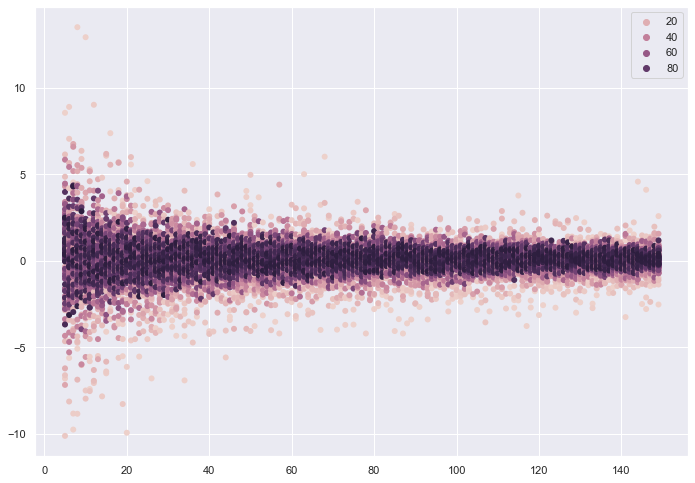

In [17]:
fig, ax = plt.subplots()

ax = sns.scatterplot(x = x, y = res, hue = out['N'].to_numpy(), linewidth=0)
# ax.scatter(x, res, s=10, color='#00b3b3', label='Data')

# Finally,

## $ S = a \kappa^b $ where,

$ a = 72.33$ and $ b = -0.50$

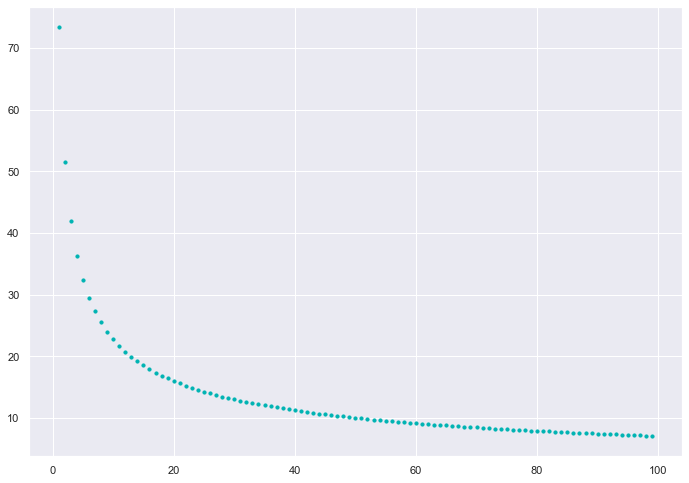

In [18]:
fig, ax = plt.subplots()
ax.scatter(range(100), power_law(np.array(range(100)), pars[0], pars[1]), s=10, color='#00b3b3', label='Data')

# Finally, we make a function that returns a kappa given a latitude and A and B parameters

In [14]:
def kappa_from_latitude(latitude_radians, a = 11.23, b=0.27):
    
    '''
    Input: given a latitude (in radians), and the $a$ and $b$ parameters that best describes the Model G that we want to simulate, 
    it returns the theoretical concentration parameter (kappa) that a sample of VGPs would have at any given latitude.
    Notes: 
    First, we use a power-law fit to find an empirical relation between kappa and angular dispersion (found to be $ S = 72.33 \kappa^-0.50 $)
    '''    
    latitude = np.degrees(np.abs(latitude_radians))
    
    S = np.sqrt(a**2+(latitude*b)**2) # approximate model G from Doubrovine et al. 2019     
    
    return 72.33 * np.power(S, -0.5)

In [12]:
kappa_from_latitude(np.radians(0))

21.58383373953327

# model G (kappa as a function of latitude)

Text(0, 0.5, 'kappa (concentration parameter)')

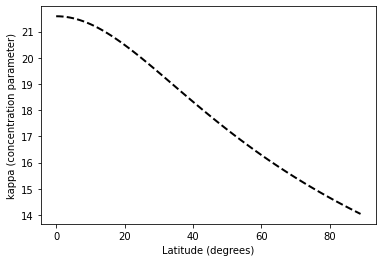

In [13]:
fig, ax = plt.subplots()

ax.plot(range(90), kappa_from_latitude(np.radians(range(90))), linestyle='--', linewidth=2, color='black')
ax.set_xlabel("Latitude (degrees)")
ax.set_ylabel("kappa (concentration parameter)")